# What is a timeseries?

A timeseries can be any data obtained via measurements at regular intervals, like the daily price of a stock, the hourly electricity consumption of a city, or the weekly sales of a store. Unlike the types of data we've encountered so far, working with timeseries involves understanding the *dynamics* of a system - its periodic cycles, how it trends over time, its regular regime and its sudden spikes.

### What is forecasting?

Predicting what will happen next in a series is called forecasting. Forecast electricity consumption a few hours in advance so you can anticipate demand; forecast revenue a few months in advance so you can plan your budget; forecast the weather a few days in advance so you can plan your schedule. 

Things can be done with timeseries:
* *Classification* - Assign one or more categorical labels to a timeseries. For instance, given the timeseries of the activity of a visitor on a website, classify whether the visitor is a bot or a human.
* *Event detection* - Identify the occurence of a specific expected event within a continuous data stream. A particularly useful application is "hotword detection," where a model monitors an audio stream and detects utterances like "Ok Google" or "Hey Alexa."
* *Anomaly detection* - Detect anything unusual happening within a continuous datastream. Unusual activity on your corporate network? Might be an attacker. Unusual readings on a manufacturing line? Time for a human to go take a look.

## A timeseries (temperature-forecasting) problem

We will tackle a single big problem of predicting the temperature 24 hours in the future, given a timeseries of hourly measurement of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building.

### The dataset we will work with

We'll work with a weather timeseries dataset recorded at the weather station at the Max Planck Institute of Biogeochemistry in Jena. In this dataset, 14 different quantities (such as temperature, pressure, humidity, wind direction, and so on) were recorded every 10 minutes over several years. The original data goes back to 2003, but the subset of the data we'll download is limited to 2009-2016.

In [ ]:
# Downloading and uncompressing the data:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-02-27 10:10:16--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.133.176, 52.216.105.253, 52.216.29.182, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.133.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  5.33MB/s    in 2.4s    

2023-02-27 10:10:20 (5.33 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [ ]:
# Inspecting the data of the Jena weather dataset
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
  data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print("Number of weather related values:", len(header[1:]))
print("Number of timesteps:", len(lines))
print(lines[:1])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of weather related values: 14
Number of timesteps: 420451
['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30']


Now, convert all 420,551 timesteps (lines) of data into NumPy arrays: one array for the temperature (in degree Celsius), and another one for the rest of the data - the features we will use to predict future temperatures.

In [ ]:
# Parsing the data
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(",")[1:]]
  temperature[i] = values[1] # We store column1 in the "temperature" array
  raw_data[i, :] = values[:] # We store all columns (including the temperature) in the "raw_data" array.

In [ ]:
print(temperature.shape)
print(raw_data.shape)  

(420451,)
(420451, 14)


Temperature span of 8 years.

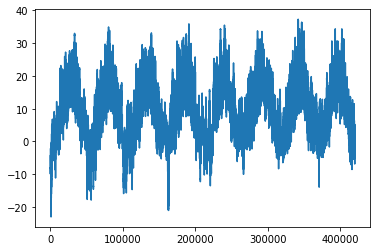

In [ ]:
# Plotting the temperature (in degree Celcius) over time (the data spans 8 years).
import matplotlib.pyplot as plt
plt.plot(range(len(temperature)), temperature);

In [ ]:
range(len(temperature))

range(0, 420451)

In [ ]:
temperature[temperature < -15]

array([-15.13, -15.2 , -15.16, ..., -15.49, -15.45, -15.11])

Temperature span of the first 10 days. Because the data is recorded every 10 minutes you get 24 x 6 = 144 data points per day and a total of 10 x 144 = 1440 for the first 10 days.

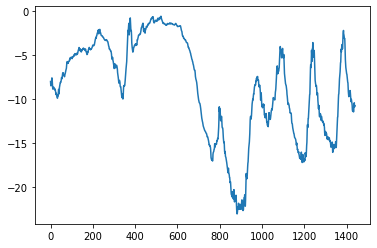

In [ ]:
# Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temperature[:1440]);

### Always look for periodicity in your data

> Periodicity over multiple timescales is an important and very common property of timeseries data. Whether you're looking at the weather, mall parking occupancy, traficto a website, sales of a grocery store, or steps logged in a fitness tracker, you'll see daily cycles and yearly cycles (human-generated data also tends to feature weekly cycles). When eploring your data, make sure to look for these patterns.

With our dataset, if you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale?

### Separation between the three sets

In all our experiments, we'll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it's important to use validation and test data that is more recent than the training data, because you're trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

In [ ]:
# Compute the number of samples we'll use for each data split
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

The exact formulation of the problem will be as follows: given data covering the previous five days and samples once per hour, can we predict the temperature in 24 hours?

First, let's preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don't need to do any vectorization. But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1000, while H2OC, measured in millimoles per mole, is around 3). We'll normalize each timeseries independently so that they all take small values on a similar scale.

In [ ]:
# Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
raw_data[:2]

array([[ 0.91365151, -1.92064015, -1.97449272, -1.86625827,  1.04801712,
        -1.29131928, -1.46715535, -0.78234525, -1.47012583, -1.4720352 ,
         2.12415558, -0.73016651, -0.77935289, -0.28119316],
       [ 0.91953033, -1.96510495, -2.01848295, -1.91992974,  1.05403079,
        -1.30447494, -1.48885833, -0.78444185, -1.48911721, -1.49346536,
         2.1729195 , -0.93230685, -0.88696976, -0.46989368]])

### Understanding `timeseries_dataset_from_array()`

To understand what `timeseries_dataset_from_array()` does, let's look at a simple example. The general idea is that you provide an array of timeseries data (the `data` argument), and `timeseries_dataset_from_array()` gives you windows extracted from the original timeseries (we'll call them "sequences").

For example, if you use data = `[0 1 2 3 4 5 6]` and `sequence_length=3`, then `timeseries_dataset_from_array()` will generate the following samples: `[0 1 2], [1 2 3], [3 4 5], [4 5 6]`.

You can also pass a `targets` argument (an array) to `timeseries_dataset_from_array().` The first entry of the `targets` array should be the same array as `data`, offset by some amount.

For instance, with `data = [0 1 2 3 4 5 6...]` and `sequence_length=3`, you could create a dataset to predict the next step in the series by passing `targets = [3 4 5 6...]`.

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], # [0 1 2 3 4 5 6]
    targets=int_sequence[3:], # [3 4 5 6 7 8 9]
    sequence_length=3, # The sequence will be 3 steps long
    batch_size=2, # The sequence will be batched in batches of size 2
)

for inputs, targets in dummy_dataset:
  for i in range(inputs.shape[0]):
    print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [ ]:
print(int_sequence[:-3])
print(int_sequence[3:])

[0 1 2 3 4 5 6]
[3 4 5 6 7 8 9]


Instantiating datasets for training, validation, and testing

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [ ]:
# Inspecting the output of one of our datasets
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 120, 14)
targets shape: (256,)


In [ ]:
# np.mean(np.abs(preds - targets))

# Computing the common-sense baseline MAE
def evaluate_naive_method(dataset):
  total_abs_err = 0.
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


This common-sense baseline achieves a validation MAE of 2.44 degrees Celsius and a test MAE of 2.62 degrees Celsius. So if you always assume that the temperature 24 hours in the future will be the same as it is now, you will be off by two and a half degrees on average.

### Let's try a basic machine learning model

In the same way that it's useful to establish a common-sense baseline before trying machine-learning approaches, it's useful to try simple, cheap machine learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs.

In [ ]:
# Traininf and evaluating a densely connected model
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True) 
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 44s 48ms/step - loss: 11.9766 - mae: 2.6766 - val_loss: 14.3345 - val_mae: 3.0159
Epoch 2/10
819/819 [==============================] - 39s 47ms/step - loss: 8.8010 - mae: 2.3317 - val_loss: 12.8991 - val_mae: 2.8426
Epoch 3/10
819/819 [==============================] - 39s 48ms/step - loss: 8.1256 - mae: 2.2443 - val_loss: 10.2721 - val_mae: 2.5118
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 7.7266 - mae: 2.1906 - val_loss: 10.6718 - val_mae: 2.5735
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 7.4044 - mae: 2.1456 - val_loss: 13.1648 - val_mae: 2.8760
Epoch 6/10
819/819 [==============================] - 40s 49ms/step - loss: 7.1945 - mae: 2.1169 - val_loss: 11.1490 - val_mae: 2.6351
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 7.0022 - mae: 2.0871 - val_loss: 11.8926 - val_mae: 2.7256
Epoch 8/10
819/819 [==============================] - 

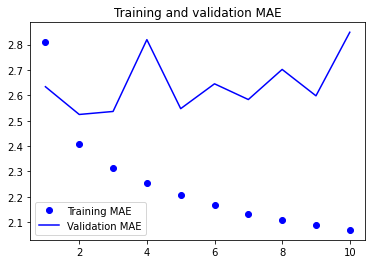

In [ ]:
# Let's display the loss curves for validation and training
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 54ms/step - loss: 23.4163 - mae: 3.7497 - val_loss: 18.5038 - val_mae: 3.3719
Epoch 2/10
819/819 [==============================] - 41s 50ms/step - loss: 15.3334 - mae: 3.1108 - val_loss: 14.4850 - val_mae: 3.0091
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 13.8432 - mae: 2.9452 - val_loss: 18.3201 - val_mae: 3.3709
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 12.8034 - mae: 2.8250 - val_loss: 15.8421 - val_mae: 3.1188
Epoch 5/10
819/819 [==============================] - 41s 49ms/step - loss: 11.9582 - mae: 2.7293 - val_loss: 17.9156 - val_mae: 3.3131
Epoch 6/10
819/819 [==============================] - 41s 49ms/step - loss: 11.3566 - mae: 2.6586 - val_loss: 16.8926 - val_mae: 3.2473
Epoch 7/10
819/819 [==============================] - 40s 49ms/step - loss: 10.9323 - mae: 2.6062 - val_loss: 14.9888 - val_mae: 3.0558
Epoch 8/10
819/819 [============================

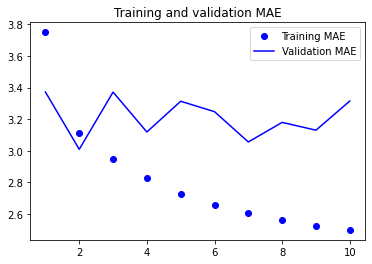

In [ ]:
# Let's display the loss curves for validation and training
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

Neither the fully connected approach nor the convolutional approach did well, but that doesn't mean machine learning isn't applicable to this problem. The densely connected approach first flattened the timeseries, which removed the notion of time from the input data. The convolutional approach treated every segment of the data in the same way, even applying pooling, which destroyed order information. Let's instead look at the data as what it is: a sequence, where casuality and order matter.

In [ ]:
# A simple LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 49s 56ms/step - loss: 41.0268 - mae: 4.6681 - val_loss: 12.3852 - val_mae: 2.6881
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 10.9383 - mae: 2.5650 - val_loss: 9.4034 - val_mae: 2.3886
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.7556 - mae: 2.4345 - val_loss: 9.2579 - val_mae: 2.3702
Epoch 4/10
819/819 [==============================] - 43s 53ms/step - loss: 9.4247 - mae: 2.3898 - val_loss: 9.1678 - val_mae: 2.3592
Epoch 5/10
819/819 [==============================] - 43s 53ms/step - loss: 9.1467 - mae: 2.3486 - val_loss: 9.3929 - val_mae: 2.3866
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9288 - mae: 2.3168 - val_loss: 9.3538 - val_mae: 2.3759
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 8.7038 - mae: 2.2845 - val_loss: 9.4234 - val_mae: 2.3842
Epoch 8/10
819/819 [==============================] - 43s 5

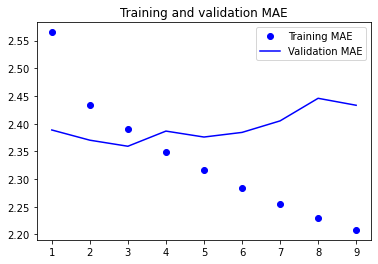

In [ ]:
# Let's display the loss curves for validation and training
import matplotlib.pyplot as plt
loss = history.history["mae"][1:]
val_loss = history.history["val_mae"][1:]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

A major characteristic of all neural networks such as densely connected networks and convnets, is that they have no memory. Each input shown to them is processed independently, with no state kept between inputs. With such networks, in order to process a sequence or a temporal seires of data points, you have to show the entire sequence to the network at once: turn it into a single data point. For instance, this is what we did in the densely connected network example: we flattened our five days of data into a single large vector and processed it in one go. Such networks are called *feedforward networks*.

In contrast, as you're reading the present sentence, you're processing it word by word - or rather, eye saccade by eye saccade - while keeping memories of what came before; this gives you a fliud representation of the meaning conveyed by this sentence.

Biological intelligence process information incrementally while maintaining an internal model of what it's processing, built from past information and constantly updated as new information comes in.

A *recurrent neural network* (RNN) adopts the same principle, albeit in an extremely simplified version: it processes sequences by iterating through the sequence elements and maintaining a *state* that contains information relative to what it has seen so far. In effect, an RNN is a type of neural network that has an internal *loop*.

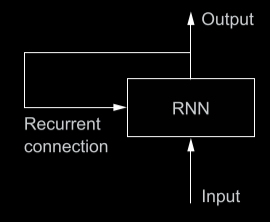



In [ ]:
# # Pseudocode RNN
# state_t = 0 # The state at t
# for input_t in input_sequence: # Iterates over sequence elements
#   output_t = f(input_t, state_t)
#   state_t = output_t # The previous output becomes the state for the next iteration.

In [ ]:
# # More detailed pseudocode for the RNN
# state_t = 0
# for input_t in input_sequence:
#   output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
#   state_t = output_t

In [ ]:
# NumPy implemetation of a simple RNN
import numpy as np

timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
  output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
  successive_outputs.append(output_t)
  state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

In [ ]:
# An RNN layer that can process sequences of any length
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = keras.layers.SimpleRNN(16)(inputs)

All recurrent layers in Keras (SimpleRNN, LSTM, GRU) can be run in two different modes: they can return either full sequences of successive outputs for each time step (a rank-3 tensor of shape `(batch_size, timesteps, output_features)`) or return only the last output for each input sequence (a rank-2 tensor of shape `(batch_size, output_features)`). 

In [ ]:
# An RNN layer that returns only its last output step
from keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
outputs.shape

TensorShape([None, 16])

In [ ]:
# An RNN layer that returns its full output sequence
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
outputs.shape

TensorShape([None, 120, 16])

In [ ]:
# Stacking RNN layers to increase the representational power of the network
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
outputs.shape

TensorShape([None, 16])

#### Idea behind LSTM

LSTM layer is a variant of the SimpleRNN layer but it adds a way to carry information across many timesteps. Imagine a conveyor belt running parallel to the sequence you're processing. Information from the sequence can jump onto the conveyor brlt at any point, be transported to a later timestep, and jump off, intact, when you need it. This is essentially what LSTM does: it save information for later, thus preventing older signals from gradually vanishing during processing.

In [ ]:
# Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25, unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs) 
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
sequence_length, raw_data.shape[-1]

(120, 14)

In [ ]:
# Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 61s 68ms/step - loss: 27.5754 - mae: 3.7718 - val_loss: 10.9982 - val_mae: 2.5782
Epoch 2/10
819/819 [==============================] - 48s 58ms/step - loss: 9.5160 - mae: 2.4046 - val_loss: 10.3499 - val_mae: 2.5046
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 8.5983 - mae: 2.2762 - val_loss: 10.1200 - val_mae: 2.4902
Epoch 4/10
417/819 [==============>...............] - ETA: 16s - loss: 8.2458 - mae: 2.2280